In [1]:
import os
import json

import pandas as pd

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

import category_encoders as ce

import warnings

warnings.filterwarnings("ignore")

In [2]:
# X = pd.read_csv('../../data/new_features/df_.csv')
# y = pd.read_csv('../../data/new_features/y.csv')

X = pd.read_csv('../../data/binned/df.csv')
y = pd.read_csv('../../data/binned/y.csv') 

for col in X.filter(like='_binned').columns:
    X[col] = X[col].astype('category')

X.filter(like='_binned').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 5 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   avg_home_team_rating_x_ewm_shoton_away_binned  3022 non-null   category
 1   average_rating_away_binned                     3040 non-null   category
 2   average_rating_home_binned                     3040 non-null   category
 3   ewm_possession_home_binned                     3024 non-null   category
 4   avg_away_team_rating_binned                    3040 non-null   category
dtypes: category(5)
memory usage: 16.0 KB


In [3]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np

def select_features(X, y, num_features=5):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the XGBClassifier
    xgb = XGBClassifier(random_state=42, enable_categorical=True)
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)
    
    # Get feature importances
    importances = xgb.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Select the best features based on feature importances
    selected_indices = indices[:num_features]
    best_features = X_train.columns[selected_indices].tolist()
    
    # Print the best features
    print("Top 5 features selected by XGBoost:")
    for index in selected_indices:
        print(f"{X_train.columns[index]}: {importances[index]}")
    
    # Alternatively, create a SelectFromModel object with a custom threshold
    # Here, we use the median as an example threshold, but you can customize it
    threshold = np.median(importances)
    selection = SelectFromModel(xgb, threshold=threshold, prefit=True)
    
    # Transform the datasets
    select_X_train = selection.transform(X_train)
    select_X_val = selection.transform(X_val)
    
    # Convert the resulting arrays back to DataFrames with column names
    selected_features = X_train.columns[(selection.get_support())]
    select_X_train = pd.DataFrame(select_X_train, columns=selected_features)
    select_X_val = pd.DataFrame(select_X_val, columns=selected_features)
    
    # Return the list of the best columns as per feature importances
    return best_features

# Assuming X_train, y_train, X_val, y_val are already defined
best_columns = select_features(X, y)

Top 5 features selected by XGBoost:
avg_home_team_rating: 0.07817720621824265
ewm_shoton_away: 0.05545411631464958
num_top_players_away: 0.0426974780857563
ewm_shoton_home: 0.03765176609158516
home_streak_wins: 0.03355275094509125


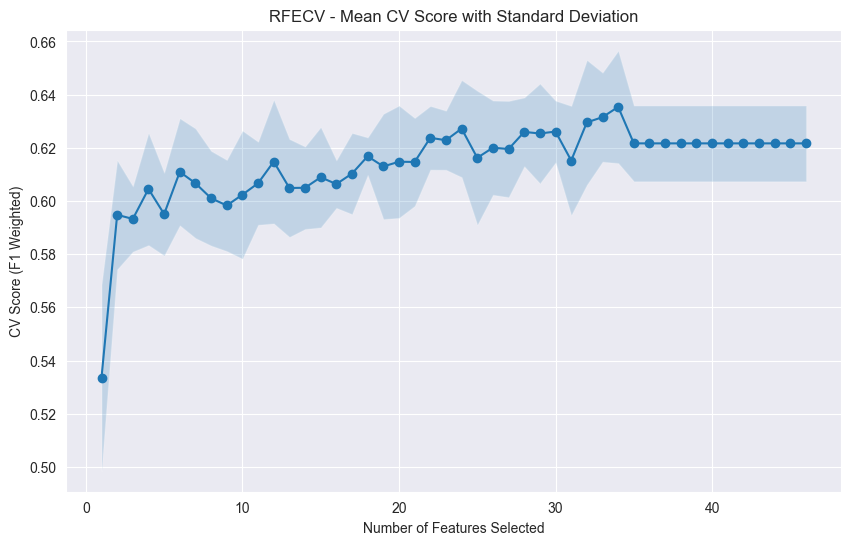

Best features: ['stage', 'player_rating_home_player_1', 'player_rating_home_player_7', 'player_rating_home_player_8', 'player_rating_home_player_9', 'player_rating_home_player_10', 'player_rating_home_player_11', 'player_rating_away_player_1', 'player_rating_away_player_7', 'player_rating_away_player_8', 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11', 'ewm_home_team_goals', 'ewm_away_team_goals', 'ewm_home_team_goals_conceded', 'ewm_away_team_goals_conceded', 'points_home', 'points_away', 'home_weighted_wins', 'away_weighted_wins', 'avg_home_team_rating', 'home_streak_wins', 'away_streak_wins', 'ewm_shoton_home', 'ewm_shoton_away', 'ewm_possession_away', 'num_top_players_home', 'num_top_players_away', 'defensive_weakness_diff', 'ewm_possession_home_x_ewm_shoton_home', 'avg_home_team_rating_x_ewm_shoton_away_binned', 'average_rating_home_binned', 'ewm_possession_home_binned']


In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import category_encoders as ce

def select_features_rfecv(X_train, y_train, cv_folds=5):
    # Initialize the encoder
    enc = ce.OrdinalEncoder(drop_invariant=True)
    
    # Encode the training data
    X_train_enc = enc.fit_transform(X_train)
    
    # Initialize the XGBClassifier
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
    # Create the RFECV model with StratifiedKFold
    rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(cv_folds, shuffle=True, random_state=42), scoring='f1_weighted')
    
    # Fit RFECV
    rfecv.fit(X_train_enc, y_train)
    
    # Accessing the cv_results_
    cv_results = rfecv.cv_results_
    
    # Plotting the mean test scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'], '-o')
    plt.fill_between(range(1, len(cv_results['mean_test_score']) + 1), 
                     cv_results['mean_test_score'] - cv_results['std_test_score'],
                     cv_results['mean_test_score'] + cv_results['std_test_score'], alpha=0.2)
    plt.title('RFECV - Mean CV Score with Standard Deviation')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('CV Score (F1 Weighted)')
    plt.show()
    
    # Extract the best features
    best_features = X_train.columns[rfecv.support_].tolist()
    print("Best features:", best_features)
    
    # Return the list of best features
    return best_features

# Assuming X_train and y_train are already defined
best_columns_rfecv = select_features_rfecv(X, y)